In [0]:
import pickle
from keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#  Load list of image info passed on from object detection
with open('/content/drive/My Drive/SVT/yolo_models/finallist_400ep.pickle', 'rb') as fp:
  finallist = pickle.load(fp)
# convert lexicon from big string to list of word strings
for ele in finallist:
  ele['lex'] = ele['lex'].split(',')
print(finallist[0]['lex'])

['CATHEDRAL', 'IMMACULATE', 'CNCPTN', 'WOLFE', 'BARBEQUE', 'RED', 'ROOM', 'RESTAURANT', 'AND', 'BAR', 'TAKI', 'COLORADO', 'STATE', 'CAPITOL', 'DENVER', 'PRIVATE', 'INVESTIGATOR', 'MILE', 'HIGH', 'INVESTIGATIONS', 'WALNUT', 'CAFE', 'JOEY', 'PIZZA', 'EMILIO', 'JERRY', 'RECORD', 'EXCHANGE', 'HILL', 'BOOKS', 'CITY', 'GRILLE', 'GREAT', 'WALL', 'CHINESE', 'SHISH', 'KABOB', 'GRILL', 'ALEX', 'SANDRA', 'REAL', 'ITALIAN', 'CHEEKY', 'MONK', 'BELGIAN', 'BEER', 'SATELLITE', 'HOLLYWOOD', 'POSTERS', 'ARCHDIOCESE', 'EDUCATION', 'ASSOCIATION']


In [0]:
with open('/content/drive/My Drive/SVT/FINAL_LEXICON.pickle', 'rb') as fp:
  # load list of possible output words
  LEXICON = pickle.load(fp)
print(LEXICON[:5])

['BLOOD', 'MICHAEL', 'FRANCIS', 'DELI', 'SHOCKS']


In [0]:
def preprocess(img):
  # preprocess image for inputting to recognition model
  
  r_img = cv2.resize(img, (100, 32))
  r_img = cv2.GaussianBlur(r_img, (5,5), 0)
  r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2GRAY)

  # maxIntensity = 255.0 
  # phi = 1
  # theta = 1
  
  # r_img = (maxIntensity/phi)*(r_img/(maxIntensity/theta))**2
  r_img = r_img.astype('float32')
  mean, std = cv2.meanStdDev(r_img)
  r_img = (r_img-mean)/std
  return r_img

In [0]:
def apply_mask(image_wordlist, label_wordlist,  ypred): 
  # applies mask on predictions based on lexicon provided with image (if any)
  # per example, ypred of shape (1, m)

  out = np.zeros((ypred.shape))
  for word in image_wordlist:
    index = label_wordlist.index(word)
    out[0, index] = 1./len(image_wordlist)

  result = ypred * out
  return result

In [0]:
def get_reslist(recog_model, finallist):
  # get updated list of dicts with new key 'pred_label' for each pred_object

  templist = copy.deepcopy(finallist)
  instance_count = 0
  for instance in finallist:
    img = cv2.imread(instance['filename'])
    i = 0
    for obj in instance['pred_object']:
      tempx = max(0, obj['xmin'])
      tempy = max(0, obj['ymin'])
      c_img = img[tempy: obj['ymax'], tempx:obj['xmax']].copy()
      c_img = preprocess(c_img)
      c_img = c_img.reshape((32,100,1))
      pred = recog_model.predict(np.expand_dims(c_img,0))
      result = apply_mask(instance['lex'], LEXICON, pred)
      word = LEXICON[np.argmax(result[0])]
      templist[instance_count]['pred_object'][i]['pred_label'] = word
      i+=1
    instance_count+=1
  return templist

In [0]:
model3 = load_model('/content/drive/My Drive/SVT/cnn_model/final_svttrain.h5')

In [0]:
tlist = get_reslist(model3, finallist)

In [0]:
# save result list to file
with open('/content/drive/My Drive/SVT/result_list.pickle', 'wb') as fp:
  pickle.dump(tlist, fp)

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=3)
pp.pprint(tlist[0])


{  'filename': '/content/drive/My Drive/SVT/img/07_07.jpg',
   'height': 1024,
   'lex': [  'CATHEDRAL',
             'IMMACULATE',
             'CNCPTN',
             'WOLFE',
             'BARBEQUE',
             'RED',
             'ROOM',
             'RESTAURANT',
             'AND',
             'BAR',
             'TAKI',
             'COLORADO',
             'STATE',
             'CAPITOL',
             'DENVER',
             'PRIVATE',
             'INVESTIGATOR',
             'MILE',
             'HIGH',
             'INVESTIGATIONS',
             'WALNUT',
             'CAFE',
             'JOEY',
             'PIZZA',
             'EMILIO',
             'JERRY',
             'RECORD',
             'EXCHANGE',
             'HILL',
             'BOOKS',
             'CITY',
             'GRILLE',
             'GREAT',
             'WALL',
             'CHINESE',
             'SHISH',
             'KABOB',
             'GRILL',
             'ALEX',
             'SANDRA',
     

In [0]:
def showres(finallist, index):
  # show image with predicted bounding and labels

  img = cv2.imread(finallist[index]['filename'])
  show_img = img.copy()
  for obj in finallist[index]['pred_object']:
    show_img = cv2.rectangle(show_img, (obj['xmin'], obj['ymin']), (obj['xmax'], obj['ymax']), color = (0,255,0), thickness = 2)
    cv2.putText(show_img, obj['pred_label'], (obj['xmin'], obj['ymin'] - 10), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color = (0,255,0), thickness = 3)
  fig, ax = plt.subplots(figsize = (8,8))
  ax.imshow(show_img)
  # fig.savefig('/content/drive/My Drive/SVT/cover.png')

***Please Scroll down to view some of the predictions made by the detection and recognition models!***


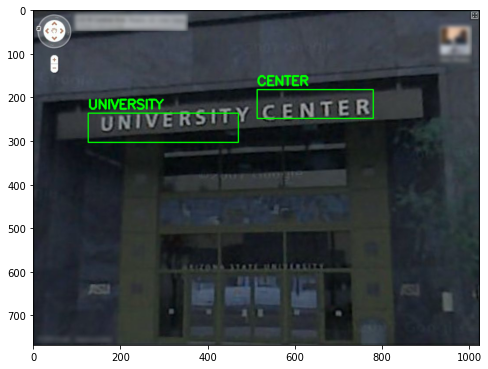

In [0]:
showres(tlist, 25)

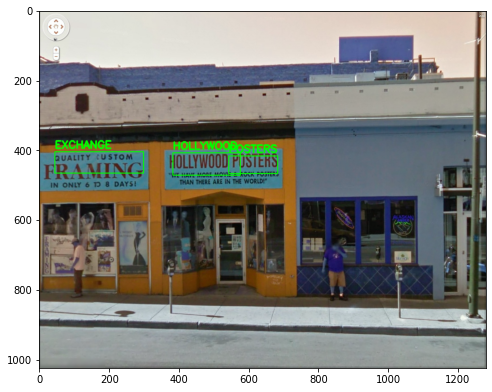

In [0]:
showres(tlist, 0)

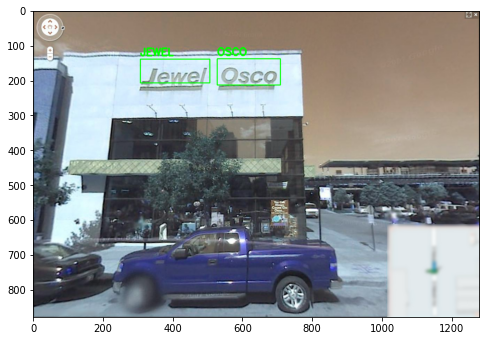

In [0]:
showres(tlist, 17)

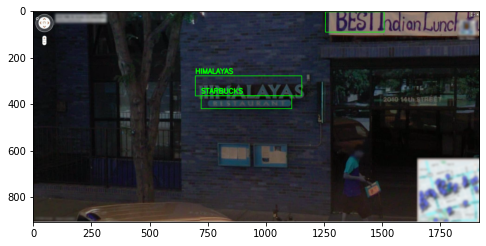

In [0]:
showres(tlist, 24)

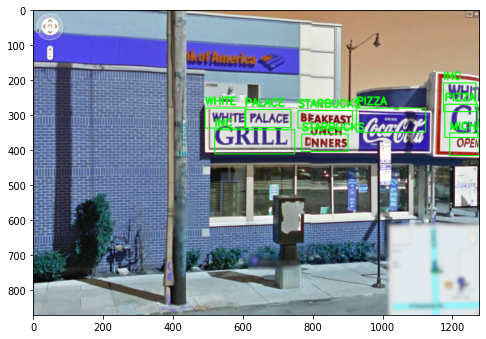

In [0]:
showres(tlist, 1)

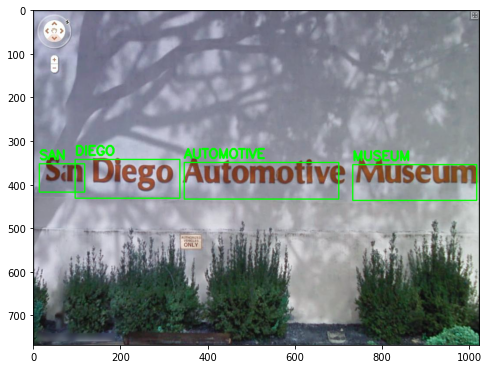

In [0]:
showres(tlist, 34)

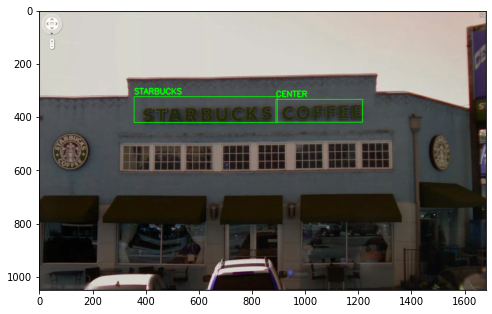

In [0]:
showres(tlist, 29)

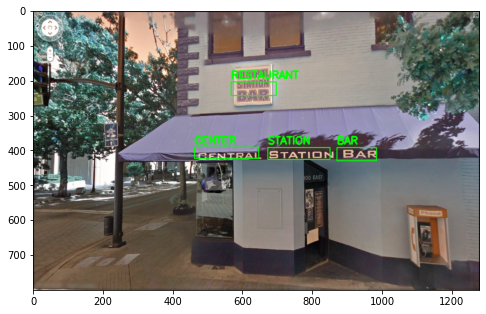

In [0]:
showres(tlist, 38)

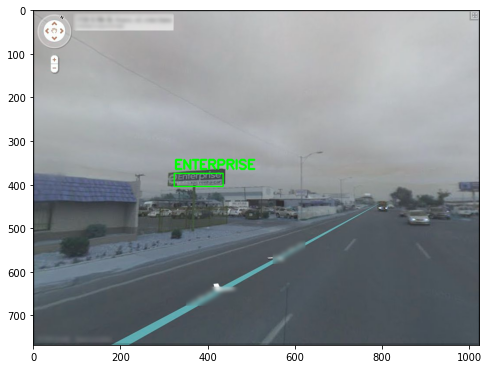

In [0]:
showres(tlist, 49)